In [816]:
import random
import numpy as np
import tensorflow as tf

# Set the random seeds
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [817]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [818]:
!pip install geopandas
!pip install simpletransformers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [819]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime as dt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler,MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle
# ! pip install plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Preprocess

In [820]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [821]:
import yfinance as yf
import pandas as pd
import numpy as np

# Define the stock symbol and the date range for which you want to download the data
symbol = 'RELIANCE.NS'
start_date = '2020-08-19'
end_date = '2021-08-19'

# Download the historical stock prices
reliance_stock = yf.download(symbol, start=start_date, end=end_date)

# Check if there are any zero values in the DataFrame
if (reliance_stock == 0).any().any():
    print("There are zero values in the DataFrame.")
else:
    print("There are no zero values in the DataFrame.")


[*********************100%***********************]  1 of 1 completed
There are no zero values in the DataFrame.


In [822]:
reliance_stock

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-08-19,2141.000000,2154.000000,2121.350098,2131.550049,2118.337402,15731396
2020-08-20,2120.000000,2123.899902,2088.000000,2097.050049,2084.051025,10401212
2020-08-21,2118.000000,2122.000000,2077.000000,2081.850098,2068.945312,11667129
2020-08-24,2091.399902,2104.500000,2070.500000,2095.750000,2082.759033,15098991
2020-08-25,2106.000000,2111.300049,2078.000000,2082.100098,2069.193848,8947563
...,...,...,...,...,...,...
2021-08-12,2124.899902,2126.199951,2105.000000,2110.500000,2104.165039,3755507
2021-08-13,2117.300049,2149.899902,2108.949951,2145.649902,2139.209229,5898384
2021-08-16,2149.350098,2203.000000,2128.149902,2173.500000,2166.975830,10123204


In [823]:
reliance_stock = reliance_stock.reset_index()

In [824]:
closedf =reliance_stock[['Date','Close']]

In [825]:
closedf

,Date,Close
0,2020-08-19,2131.550049
1,2020-08-20,2097.050049
2,2020-08-21,2081.850098
3,2020-08-24,2095.750000
4,2020-08-25,2082.100098
...,...,...
245,2021-08-12,2110.500000
246,2021-08-13,2145.649902
247,2021-08-16,2173.500000
248,2021-08-17,2164.250000


### Dataset Creation

In [826]:
close_stock = closedf.copy()
del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(250, 1)


In [827]:
training_size=int(len(closedf)*0.65)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size],closedf[training_size:len(closedf)]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (162, 1)
test_data:  (88, 1)


In [828]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [829]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (146, 15)
y_train:  (146,)
X_test:  (72, 15)
y_test (72,)


### KNN

In [830]:
from sklearn import neighbors

K = time_step
neighbor = neighbors.KNeighborsRegressor(n_neighbors = K)
neighbor.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=15)

In [831]:
# Lets Do the prediction 

train_predict=neighbor.predict(X_train)
test_predict=neighbor.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (146, 1)
Test data prediction: (72, 1)


In [832]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

train_predict_KNN = copy.deepcopy(train_predict)
test_predict_KNN = copy.deepcopy(test_predict)

### Evaluation 
**RMSE, MSE and MAE**
Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data.

In [833]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  48.35734742134853
Train data MSE:  2338.433049629003
Train data MAE:  36.269711456995616
-------------------------------------------------------------------------------------
Test data RMSE:  57.92543467002767
Test data MSE:  3355.355981711644
Test data MAE:  42.39323131419994


**R2 score**

R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.

1 = Best 

0 or < 0 = worse

In [834]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.8307161756220045
Test data R2 score: 0.5741666618682901


### Linear Regression

In [835]:
# Importing necessary libraries
from sklearn.linear_model import LinearRegression

# Creating an instance of Linear Regression model
regressor = LinearRegression()

# Fitting the training data to the model
regressor.fit(X_train, y_train)

# Predicting the values for test data
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)


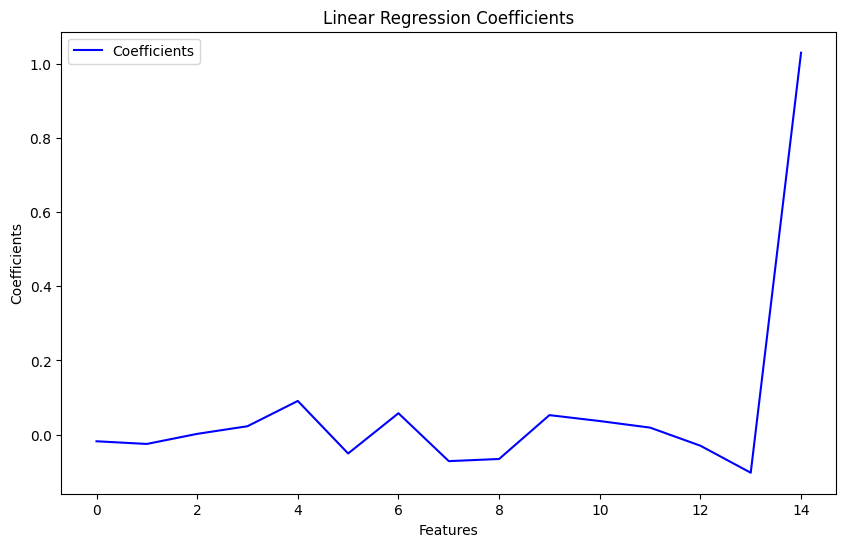

Coefficients:  [-0.01797891 -0.02520881  0.00197387  0.02256471  0.09072259 -0.0508786
  0.0575836  -0.07152543 -0.0656958   0.05247759  0.03654481  0.01881395
 -0.0299395  -0.10274935  1.02927661]


In [836]:
import matplotlib.pyplot as plt

# Plotting the coefficients
plt.figure(figsize=(10,6))
plt.plot(regressor.coef_, color='blue', label='Coefficients')
plt.title('Linear Regression Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.legend()
plt.show()
# Printing the coefficients
print("Coefficients: ", regressor.coef_)


In [837]:
train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (146, 1)
Test data prediction: (72, 1)


In [838]:
# Transform back to original form
import copy

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

train_predict_LR = copy.deepcopy(train_predict)
test_predict_LR = copy.deepcopy(test_predict)

In [839]:
train_predict_LR

array([[2103.52263069],
       [2167.10594919],
       [2309.13864575],
       [2296.99029905],
       [2277.49942288],
       [2300.62267179],
       [2314.81617054],
       [2292.12580051],
       [2285.99191418],
       [2223.64675963],
       [2191.81967201],
       [2216.99346139],
       [2176.01100605],
       [2205.78199671],
       [2214.20794426],
       [2236.46227609],
       [2227.83507249],
       [2213.95821504],
       [2205.70410251],
       [2207.78152135],
       [2246.94510674],
       [2223.96760975],
       [2212.89688026],
       [2222.96311619],
       [2270.39710453],
       [2279.45568825],
       [2189.80590553],
       [2163.61313414],
       [2173.61383436],
       [2150.61293936],
       [2119.39102939],
       [2096.51363341],
       [2110.16625241],
       [2027.33583199],
       [2039.59740314],
       [2021.39998592],
       [2035.22417431],
       [2056.53296983],
       [1864.67886094],
       [1859.6155457 ],
       [1938.0408807 ],
       [1968.088

### Evaluation 
**RMSE, MSE and MAE**

Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data.

In [840]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  38.32881268682413
Train data MSE:  1469.0978819816505
Train data MAE:  27.614521888477867
-------------------------------------------------------------------------------------
Test data RMSE:  27.29430137761144
Test data MSE:  744.9788876918818
Test data MAE:  20.734685762352807


**R2 score**
R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.

1 = Best \\

0 or < 0 = worse

In [841]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.8936490792896881
Test data R2 score: 0.9054535946967831


#### Plot the predictions 

In [842]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (250, 1)
Test predicted data:  (250, 1)


### XGBoost

In [843]:
# Import necessary libraries
from sklearn.model_selection import GridSearchCV

# Set up the parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200]
}

# Initialize the model
xgb_model = xgb.XGBRegressor()

# Run GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding MSE score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best MSE score: ", -grid_search.best_score_)


Best hyperparameters:  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}
Best MSE score:  0.022822247471902417


In [844]:
### Lets Do the prediction and check performance metrics
train_predict=grid_search.predict(X_train).reshape((146,1))
test_predict=grid_search.predict(X_test).reshape((72,1))
train_predict.shape, test_predict.shape

((146, 1), (72, 1))

In [845]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

train_predict_XGB = copy.deepcopy(train_predict)
test_predict_XGB = copy.deepcopy(test_predict)

### Evaluation 
**RMSE, MSE and MAE**

Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data.

In [846]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  28.195115416626216
Train data MSE:  794.9645333568733
Train data MAE:  21.821921988709338
-------------------------------------------------------------------------------------
Test data RMSE:  43.51826644405873
Test data MSE:  1893.839514296088
Test data MAE:  34.26370578342013


**R2 score**
R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.

1 = Best \\

0 or < 0 = worse

In [847]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9424509346235631
Test data R2 score: 0.7596499427619464


In [848]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (250, 1)
Test predicted data:  (250, 1)


### LSTM

In [849]:
X_train_LSTM =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test_LSTM = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [850]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [851]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 15, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [852]:
model.fit(X_train_LSTM,y_train,validation_data=(X_test_LSTM,y_test),epochs=200,batch_size=5,verbose=1)

Epoch 1/200
30/30 [==============================] - 6s 44ms/step - loss: 0.0742 - val_loss: 0.0267
Epoch 2/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0319 - val_loss: 0.0294
Epoch 3/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0310 - val_loss: 0.0271
Epoch 4/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0339 - val_loss: 0.0539
Epoch 5/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0285 - val_loss: 0.0473
Epoch 6/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0319 - val_loss: 0.0242
Epoch 7/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0254 - val_loss: 0.0183
Epoch 8/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0239 - val_loss: 0.0171
Epoch 9/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0258 - val_loss: 0.0227
Epoch 10/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0260 - val_loss: 0.0154
Epoch 11

In [853]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train_LSTM)
test_predict=model.predict(X_test_LSTM)
train_predict.shape, test_predict.shape

3/3 [==============================] - 0s 4ms/step


((146, 1), (72, 1))

In [854]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

train_predict_LSTM = copy.deepcopy(train_predict)
test_predict_LSTM = copy.deepcopy(test_predict)

In [855]:
train_predict

array([[2121.5317],
       [2171.5095],
       [2302.9512],
       [2286.069 ],
       [2311.1848],
       [2318.2312],
       [2270.8188],
       [2248.6582],
       [2250.6396],
       [2215.372 ],
       [2179.0867],
       [2189.822 ],
       [2167.1348],
       [2183.4934],
       [2210.9888],
       [2225.621 ],
       [2194.87  ],
       [2214.0425],
       [2228.2646],
       [2206.3057],
       [2240.0608],
       [2219.9358],
       [2212.2856],
       [2236.9377],
       [2274.1462],
       [2262.2056],
       [2180.6533],
       [2168.398 ],
       [2158.2878],
       [2144.6868],
       [2114.2434],
       [2093.509 ],
       [2101.2048],
       [2013.4617],
       [1999.3071],
       [2004.0663],
       [2005.085 ],
       [2001.9542],
       [1854.7559],
       [1898.2157],
       [1953.0011],
       [1990.3837],
       [2050.37  ],
       [2067.1208],
       [2013.3579],
       [1961.3635],
       [1977.4183],
       [1962.8119],
       [1984.6654],
       [1983.9607],


### Evaluation 
**RMSE, MSE and MAE**

Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data.

In [856]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  30.53984143904392
Train data MSE:  932.681915121944
Train data MAE:  22.701324044841606
-------------------------------------------------------------------------------------
Test data RMSE:  39.75744201883119
Test data MSE:  1580.6541958807243
Test data MAE:  31.40853203667536


**R2 score**
R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.

1 = Best \\

0 or < 0 = worse

In [857]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9324812991566789
Test data R2 score: 0.7993967685299307


In [858]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (250, 1)
Test predicted data:  (250, 1)


### Ensemble 

In [859]:
# Stack the individual predictions into a single feature matrix
X_meta = np.column_stack((train_predict_KNN , train_predict_XGB, train_predict_LSTM))

original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [860]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15]
}

# Create a random forest regressor object
rf_model = RandomForestRegressor(random_state=42)

# Create a grid search object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit the grid search object to the data
grid_search.fit(X_meta, original_ytrain.ravel())

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", -grid_search.best_score_)

# Train a random forest model on the stacked predictions using the best hyperparameters
best_n_estimators = grid_search.best_params_['n_estimators']
best_max_depth = grid_search.best_params_['max_depth']
rf_model = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=best_max_depth, random_state=42)
rf_model.fit(X_meta, original_ytrain.ravel())

# Predict the target variable on the test set
y_pred = rf_model.predict(np.column_stack((test_predict_KNN, test_predict_XGB, test_predict_LSTM)))
y_pred = y_pred.reshape((72,1))
original_ytest = original_ytest.ravel()
y_train = rf_model.predict(X_meta)
y_train = y_train.reshape((146,1))

# Evaluate the performance of the random forest model
mse_rf = mean_squared_error(original_ytest, y_pred)
r2_rf = r2_score(original_ytest, y_pred)
print(f"Random forest MSE: {mse_rf:.4f}")
print(f"Random forest R2 score: {r2_rf:.4f}")


Best parameters:  {'max_depth': 10, 'n_estimators': 50}
Best score:  1408.7729367838042
Random forest MSE: 1962.3957
Random forest R2 score: 0.7509


In [862]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,y_train)))
print("Train data MSE: ", mean_squared_error(original_ytrain,y_train))
print("Train data MAE: ", mean_absolute_error(original_ytrain,y_train))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,y_pred)))
print("Test data MSE: ", mean_squared_error(original_ytest,y_pred))
print("Test data MAE: ", mean_absolute_error(original_ytest,y_pred))

Train data RMSE:  8.057651826786085
Train data MSE:  64.92575296170914
Train data MAE:  5.968708553481811
-------------------------------------------------------------------------------------
Test data RMSE:  44.298935303107065
Test data MSE:  1962.3956689888655
Test data MAE:  35.46499806036797


In [809]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(y_train)+look_back, :] = y_train
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train)+(look_back*2)+1:len(closedf)-1, :] = y_pred
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (250, 1)
Test predicted data:  (250, 1)


## LSTM with Sentiment

In [441]:
# Download India news dataset 
india_news = pd.read_csv('/content/drive/MyDrive/india-news-headlines.csv')
india_news['publish_date'] = pd.to_datetime(india_news['publish_date'], format='%Y%m%d')

In [442]:
india_news

,publish_date,headline_category,headline_text
0,2001-01-02,unknown,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-02,unknown,Fissures in Hurriyat over Pak visit
2,2001-01-02,unknown,America's unwanted heading for India?
3,2001-01-02,unknown,For bigwigs; it is destination Goa
4,2001-01-02,unknown,Extra buses to clear tourist traffic
...,...,...,...
3650965,2022-03-31,city.srinagar,J&K sacks 2 cops; 3 other employees over terro...
3650966,2022-03-31,entertainment.hindi.bollywood,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650967,2022-03-31,city.trichy,As Covid-19 cases drop to nil in southern dist...
3650968,2022-03-31,city.erode,Tamil Nadu sees marginal rise of Covid cases w...


In [443]:
# Filter the news between Aug 2020 - Aug 2021
india_news = india_news[india_news['publish_date'] > '2020-08-18']
india_news = india_news[india_news['publish_date'] < '2021-08-19'].reset_index(drop = True)
india_news

,publish_date,headline_category,headline_text
0,2020-08-19,city.surat,Rough diamond import decline 82% in April-July...
1,2020-08-19,city.kolhapur,Chikali; Ambewadi residents leave as Panchagan...
2,2020-08-19,city.ahmedabad,SC dismisses state govt's appeal
3,2020-08-19,entertainment.kannada.movies.news,Prem gets nostalgic about his Shivarajkumar fi...
4,2020-08-19,life-style.spotlight,Drive-in theatres looking to capitalise in pos...
...,...,...,...
182044,2021-08-18,city.goa,FSDL acquires media rights for AFC competitions
182045,2021-08-18,city.goa,Need passionate people for sports to succeed; ...
182046,2021-08-18,city.delhi,No end in sight to waste problem; East Delhi M...
182047,2021-08-18,city.delhi,Quality education; health taking Delhi on US g...


In [444]:
# Import nltk for text preprocessing
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [445]:
# Preprocess text data
from nltk.corpus import stopwords
from string import punctuation

def remove_stopwords_and_punctuations(tokens):
    # Convert stopwords set to lowercase
    stop_words = set(stopwords.words('english'))
    
    # Filter out stopwords and punctuations
    filtered_tokens = [token.lower() for token in tokens if token.lower() not in stop_words and token not in punctuation]
    
    return filtered_tokens

# Tokenize the text column
india_news['tokenized_text'] = india_news['headline_text'].apply(nltk.word_tokenize)

# Remove stopwords and punctuations
india_news['tokenized_text'] = india_news['tokenized_text'].apply(remove_stopwords_and_punctuations)


KeyboardInterrupt: ignored

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
# Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the fine-tuned FinBERT model and tokenizer
model_path = "ProsusAI/finbert"
tokenizer_path = "ProsusAI/finbert"

model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
model.to(device)

In [ ]:
def get_sentiment_scores(tokenized_texts):
    texts = [' '.join(tokens) for tokens in tokenized_texts]
    inputs = tokenizer([text[0] for text in texts], padding=True, truncation=True, return_tensors="pt")
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    # Get the predicted sentiment score
    outputs = model(**inputs)
    
    # Calculate probabilities from logits
    probabilities = torch.softmax(outputs.logits, dim=-1).detach().cpu().numpy()  # Add the detach() method here
    # scores = torch.softmax(outputs.logits, dim=1).detach().cpu().numpy()
    # print(scores)
    
    # Use the positive class probability as the continuous sentiment score
    sentiment_scores = probabilities[:, 1]

    
    # Return the sentiment score
    # return {"positive": scores[:,1], "negative": scores[:,0]}


    
    # # Normalize the sentiment scores to the range [-1, 1]
    # sentiment_scores = 2 * sentiment_scores - 1
    
    return sentiment_scores

# Process the tokenized texts in batches
batch_size = 64
n_batches = int(np.ceil(len(india_news) / batch_size))
sentiment_scores = []

for i in range(n_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    
    batch_tokenized_texts = india_news['tokenized_text'][start_idx:end_idx].tolist()
    batch_sentiment_scores = get_sentiment_scores(batch_tokenized_texts)
    sentiment_scores.extend(batch_sentiment_scores)

In [ ]:
# Add the sentiment scores to the DataFrame
india_news['sentiment_score'] = sentiment_scores

In [ ]:
india_news